### Install the Prerequisite Libraries

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# imports
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Data Preprocessing and EDA

As the test data has been provided beforehand, we opt in to use that as the benchmark test data. Thus we load the separate files into train and test data respectively. On another case, we would have to otherwise split the data using sklearn's **train_test_split**

In [3]:
# load data
train_filepath = 'customer_churn/train_data.csv'
test_filepath = 'customer_churn/test_data.csv'

# train and test data
train_data = pd.read_csv(train_filepath)
test_data = pd.read_csv(test_filepath)

print(train_data.columns)
print(train_data.head())

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Churn'],
      dtype='object')
   CustomerID   Age  Gender  Tenure  Usage Frequency  Support Calls  \
0         2.0  30.0  Female    39.0             14.0            5.0   
1         3.0  65.0  Female    49.0              1.0           10.0   
2         4.0  55.0  Female    14.0              4.0            6.0   
3         5.0  58.0    Male    38.0             21.0            7.0   
4         6.0  23.0    Male    32.0             20.0            5.0   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0           18.0          Standard          Annual        932.0   
1            8.0             Basic         Monthly        557.0   
2           18.0             Basic       Quarterly        185.0   
3            7.0          Standard         Monthly        396.0   
4            8.0

In [4]:
train_data.describe()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,225398.667955,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,129531.918550,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,2.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


### Handle Null Values

In [5]:
# find the total null values in the dataframe
print(train_data.isna().sum())
print(test_data.isna().sum())

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64
CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64


We locate that all the null entries in the dataframe are in a single row. That makes it easier to get rid of this single row

In [6]:
# store the indices of the null values
ids = train_data[train_data['CustomerID'].isna() == True].index

train_data = train_data.drop(ids)
print(train_data.isna().sum()) 
print(train_data.head(3))

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64
   CustomerID   Age  Gender  Tenure  Usage Frequency  Support Calls  \
0         2.0  30.0  Female    39.0             14.0            5.0   
1         3.0  65.0  Female    49.0              1.0           10.0   
2         4.0  55.0  Female    14.0              4.0            6.0   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0           18.0          Standard          Annual        932.0   
1            8.0             Basic         Monthly        557.0   
2           18.0             Basic       Quarterly        185.0   

   Last Interaction  Churn  
0              17.0    1.0  
1               6.0    1.0  
2               3.0    1.0  


The CustomerID doesnt have any significance for us, so we get rid of this column

In [7]:
# drop the customerID column
customer_id_tr = train_data['CustomerID']
customer_id_ts = test_data['CustomerID']
train_data.drop(['CustomerID'], axis = 1, inplace = True)
test_data.drop(['CustomerID'], axis = 1, inplace = True)

In [8]:
train_data.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


### Convert Categorical to Numerical Features

We create dummy columns for different categorical values in a column to represent as numerical features

In [9]:
# create dummy columns and store them in backup cols
gender_tr = pd.get_dummies(train_data['Gender'], drop_first = True, dtype = float)
sub_type_tr = pd.get_dummies(train_data['Subscription Type'], drop_first = True, dtype = float)
contract_len_tr = pd.get_dummies(train_data['Contract Length'], drop_first = True, dtype = float)

# both the train and test data have same set of unique values in these columns
gender_ts = pd.get_dummies(test_data['Gender'], drop_first = True, dtype = float)
sub_type_ts = pd.get_dummies(test_data['Subscription Type'], drop_first = True, dtype = float)
contract_len_ts = pd.get_dummies(test_data['Contract Length'], drop_first = True, dtype = float)

# drop the original columns
train_data.drop(['Gender', 'Subscription Type', 'Contract Length'], inplace = True, axis = 1)
test_data.drop(['Gender', 'Subscription Type', 'Contract Length'], inplace = True, axis = 1)
print(train_data.head(1))
print(test_data.head(1))

# add the new columns
train_data = pd.concat([train_data, gender_tr, sub_type_tr, contract_len_tr], axis = 1)
test_data = pd.concat([test_data, gender_ts, sub_type_ts, contract_len_ts], axis = 1)
print(train_data.head(1))
print(test_data.head(1))

    Age  Tenure  Usage Frequency  Support Calls  Payment Delay  Total Spend  \
0  30.0    39.0             14.0            5.0           18.0        932.0   

   Last Interaction  Churn  
0              17.0    1.0  
   Age  Tenure  Usage Frequency  Support Calls  Payment Delay  Total Spend  \
0   22      25               14              4             27          598   

   Last Interaction  Churn  
0                 9      1  
    Age  Tenure  Usage Frequency  Support Calls  Payment Delay  Total Spend  \
0  30.0    39.0             14.0            5.0           18.0        932.0   

   Last Interaction  Churn  Male  Premium  Standard  Monthly  Quarterly  
0              17.0    1.0   0.0      0.0       1.0      0.0        0.0  
   Age  Tenure  Usage Frequency  Support Calls  Payment Delay  Total Spend  \
0   22      25               14              4             27          598   

   Last Interaction  Churn  Male  Premium  Standard  Monthly  Quarterly  
0                 9      1   0

### Observe Outliers 

We try to find outliers in the numerical features. Fortunately, we **do not have** any outliers in this data

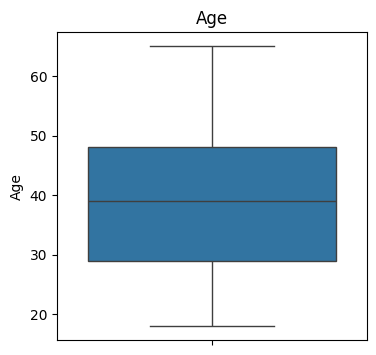

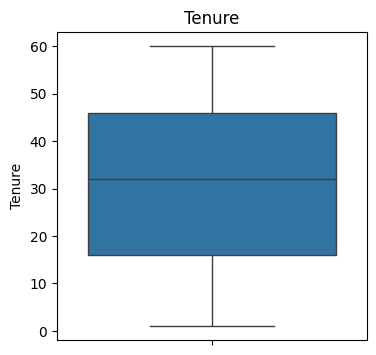

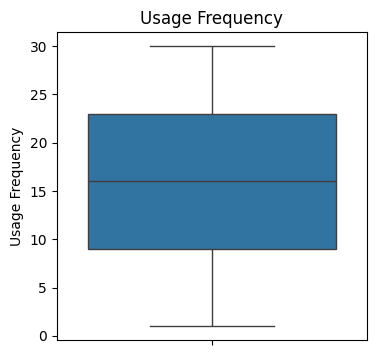

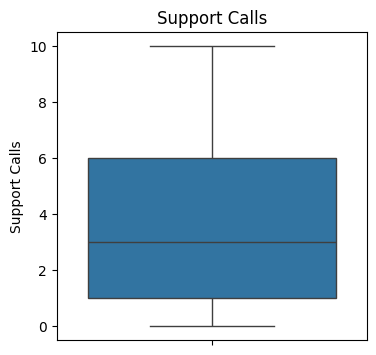

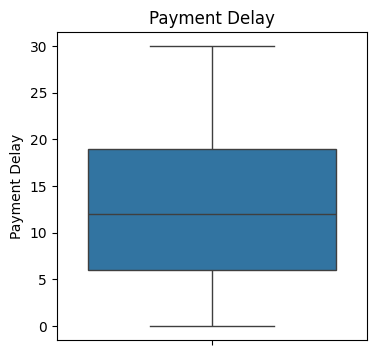

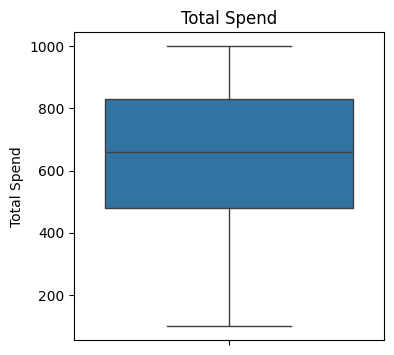

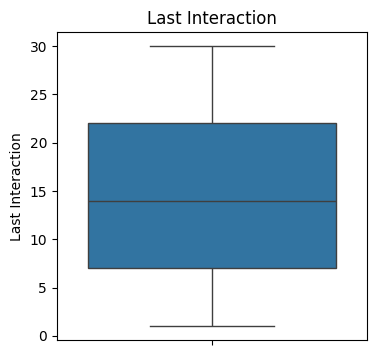

In [10]:
for col in train_data.columns:
    if col != 'Churn' and len(train_data[col].unique()) > 2:
        plt.figure(figsize=(4,4))
        sns.boxplot(train_data[col])
        plt.title(col)
        plt.show()

### Observe Distributions

We check if the data generally follows normal distribution by the below distribution plots (**Univariate Analysis**). We observe that apart from the binary columns, almost all  of the columns do not follow standard normal distribution. In this case, we need to apply StandardScaler / MinMaxScaler from scipy.  

<Figure size 1200x500 with 0 Axes>

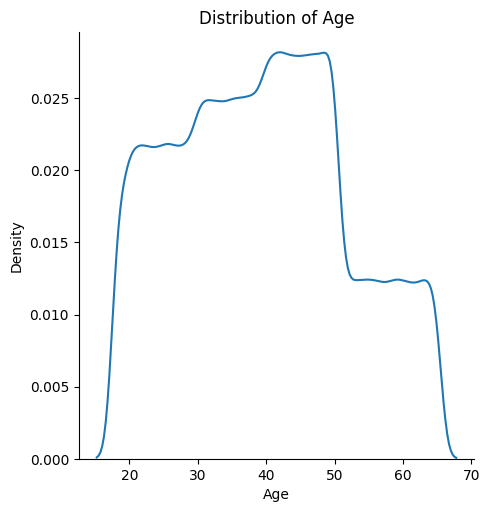

<Figure size 1200x500 with 0 Axes>

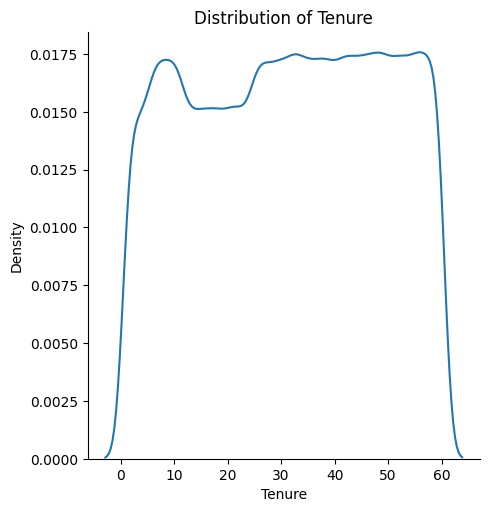

<Figure size 1200x500 with 0 Axes>

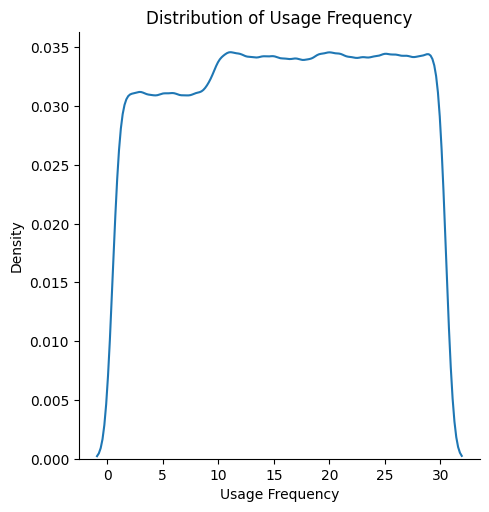

<Figure size 1200x500 with 0 Axes>

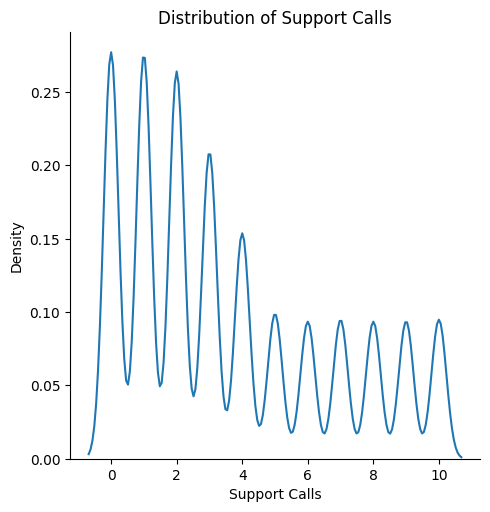

<Figure size 1200x500 with 0 Axes>

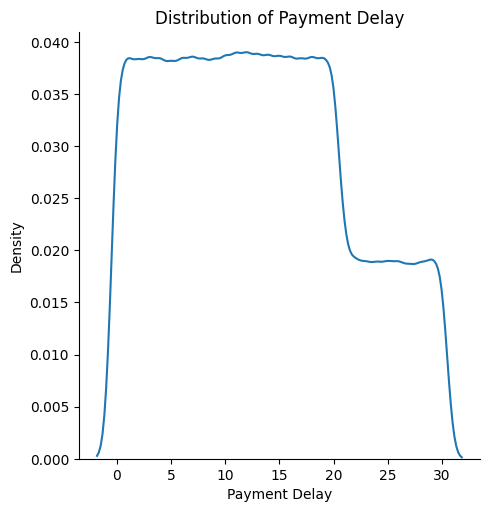

<Figure size 1200x500 with 0 Axes>

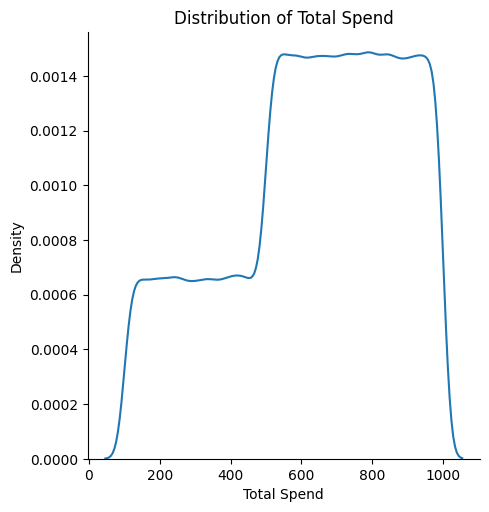

<Figure size 1200x500 with 0 Axes>

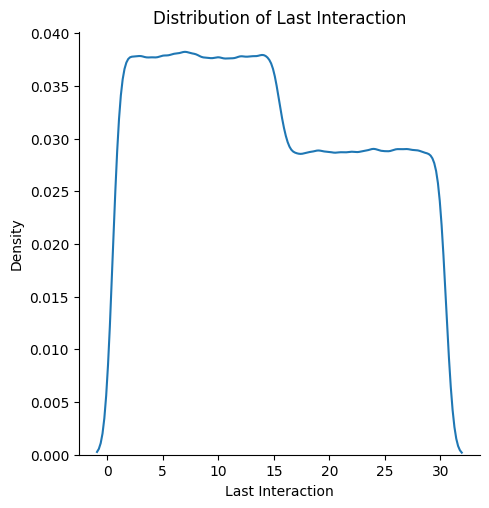

<Figure size 1200x500 with 0 Axes>

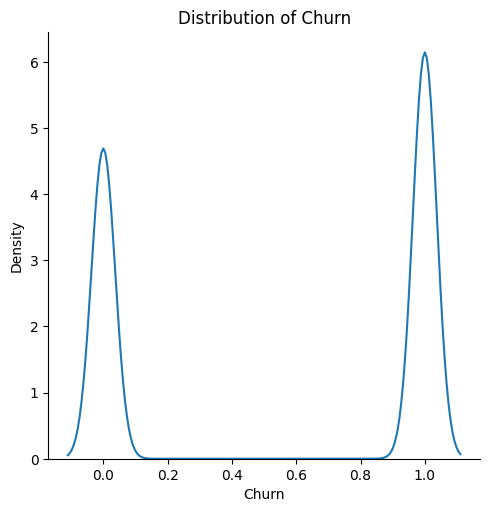

<Figure size 1200x500 with 0 Axes>

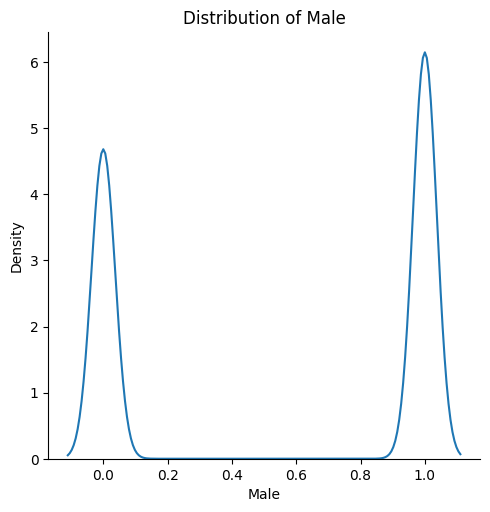

<Figure size 1200x500 with 0 Axes>

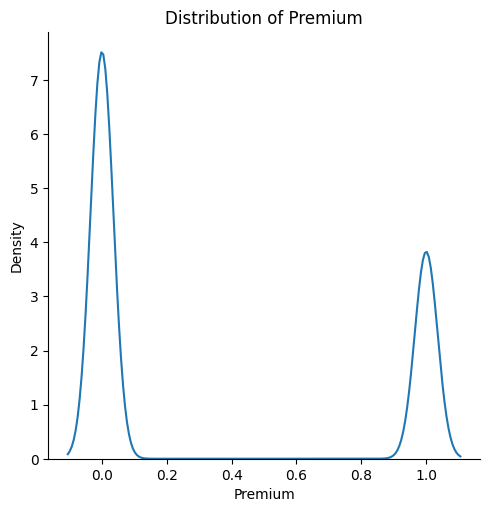

<Figure size 1200x500 with 0 Axes>

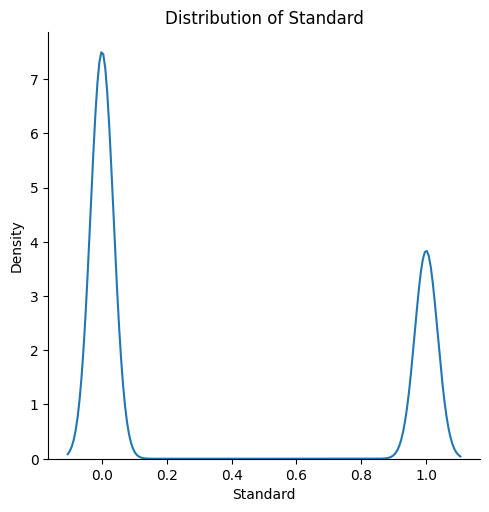

<Figure size 1200x500 with 0 Axes>

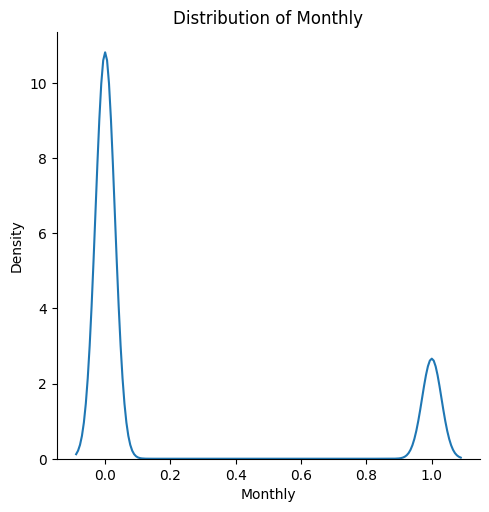

<Figure size 1200x500 with 0 Axes>

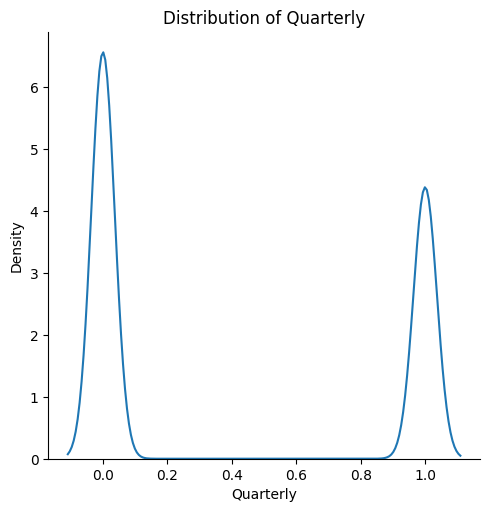

In [11]:
# plot histograms
for col in train_data.columns:
    plt.figure(figsize=(12, 5))
    
    # Histogram
    sns.displot(data = train_data, x = col, kind='kde')
    plt.title(f'Distribution of {col}')
    plt.show()

### Log Transformation

We convert the distributions of the non-binary features to their logarithms. This way, we approximately assume the normal shape of distributions. As we have a lot of zeros in the distributions, we need to add a very small value to the zeros (epsilon = 1e-10) to avoid disruptions while doing the logarithm.

The log transformation step <b><font color='red'> did not result in a better model performance </font> </b> , hence we keep these cells ignored for the rest of the notebook

### Separate Feature and Target Variables

Here we create X_train, y_train and X_test, y_test for our Machine Learning task from the train_data and test_data respectively.  
This in turn helps us relate the feature to target variables in Exploratory Data Analysis phase before model training.

In [12]:
# dividing the data into two parts : predictors, targets
X_train = train_data.drop(columns = ['Churn'], axis = 1)
y_train = train_data['Churn']

X_test = test_data.drop('Churn', axis = 1)
y_test = test_data['Churn']

print(f'X_train.shape : {X_train.shape}')
print(f'y_train.shape : {y_train.shape}')
print(f'X_test.shape : {X_test.shape}')
print(f'y_test.shape : {y_test.shape}')

X_train.shape : (440832, 12)
y_train.shape : (440832,)
X_test.shape : (64374, 12)
y_test.shape : (64374,)


### Scale Features

Algorithms that use gradient descent optimization, such as logistic regression and neural networks, converge faster when the features are standardized

In [13]:
# create backups for the unscaled data
X_train_bk = X_train.copy()
X_test_bk = X_test.copy()

# fit the scaler on the training data
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler.fit(X_train)

# transform both training and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# convert back to DataFrame for easy viewing
X_train = pd.DataFrame(X_train, columns=X_train_bk.columns)
X_test = pd.DataFrame(X_test, columns=X_test_bk.columns)

print("Scaled Data:")
print(X_train.head())

Scaled Data:
        Age    Tenure  Usage Frequency  Support Calls  Payment Delay  \
0 -0.753326  0.448760        -0.210511       0.454549       0.609620   
1  2.059646  1.028278        -1.724562       2.083100      -0.601319   
2  1.255940 -1.000036        -1.375166       0.780259       0.609620   
3  1.497051  0.390808         0.604748       1.105969      -0.722413   
4 -1.315921  0.043097         0.488282       0.454549      -0.601319   

   Total Spend  Last Interaction      Male   Premium  Standard   Monthly  \
0     1.247427          0.293052 -1.145909 -0.713374  1.398594 -0.496232   
1    -0.309865         -0.986584 -1.145909 -0.713374 -0.715004  2.015188   
2    -1.854698         -1.335575 -1.145909 -0.713374 -0.715004 -0.496232   
3    -0.978462          1.689018  0.872670 -0.713374  1.398594  2.015188   
4    -0.060698          0.642043  0.872670 -0.713374 -0.715004  2.015188   

   Quarterly  
0  -0.817258  
1  -0.817258  
2   1.223604  
3  -0.817258  
4  -0.817258  


In [14]:
train_data.columns

Index(['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay',
       'Total Spend', 'Last Interaction', 'Churn', 'Male', 'Premium',
       'Standard', 'Monthly', 'Quarterly'],
      dtype='object')

### Assess Correlations 

Observe the correlations between each set of target and feature variable pairs. This way we decide to drop two dummy columns **'Premium'** and **'Standard'** (created from the original column **'Subscription Type'**), and two more columns **'Tenure'** and **'Usage Frequency'**, as they have very low absolute correlation value with the target variable Churn. The columns with low absolute correlation values confuse the machine learning model while training, they cause hindrance for the learning of patterns or relations within the data for the model.

               col       val
0              Age  0.218345
1           Tenure -0.051868
2  Usage Frequency -0.046052
3    Support Calls  0.573942
4    Payment Delay  0.311950


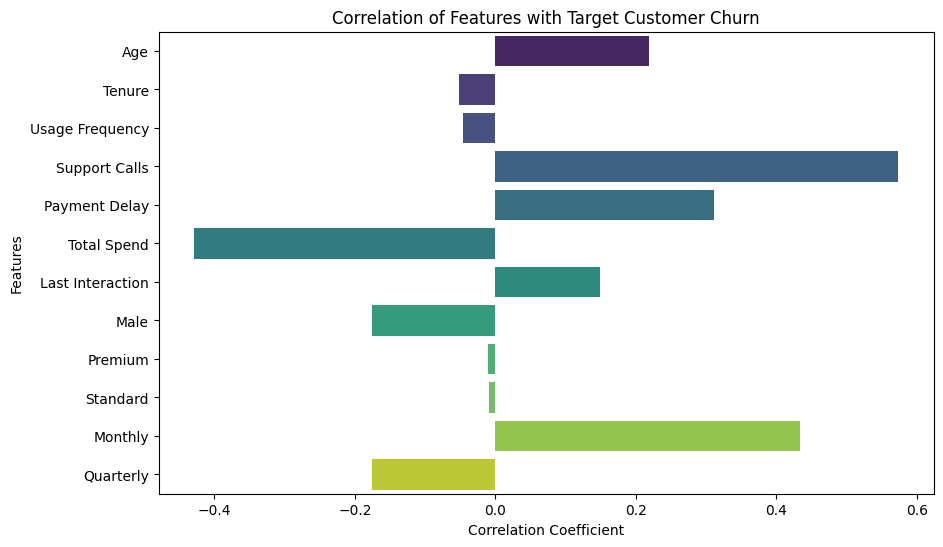

In [15]:
corrs = pd.DataFrame(columns = ['col', 'val'])
corrs = pd.DataFrame([{'col': col_val, 'val': float(X_train[col_val].corr(y_train))} for col_val in X_train.columns])
# print(corrs)

corrs = pd.DataFrame.from_dict(corrs)
print(corrs.head())

# plot
plt.figure(figsize=(10, 6))
sns.barplot(x='val', y='col', data=corrs, palette='viridis', hue = 'col')
plt.title('Correlation of Features with Target Customer Churn')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

In [16]:
# drop the lowly correlated columns 
columns_to_drop = ['Tenure', 'Usage Frequency', 'Premium', 'Standard']
X_train.drop(columns_to_drop, axis = 1, inplace = True)
X_test.drop(columns_to_drop, axis = 1, inplace = True)

**N.B:**

We can get rid of more feature columns which possess similar correlationship between them. If two feature column X is highly correlated with target column Z and if another feature column Y is highly correlated with column X, then feature column Y would not contribute much to the training of the ML model in question. This way, feature column Y could be dropped off without hindering the training quality, rather improving efficiency. But this scenario is ideal in case we have a large set of features. In this experiment, we only have a few columns as features, so we ignore this part here


### Feature Selection Using Lasso Regression

The lasso regression helps us determine the useful features for model training. By using **GridSearchCV** from sklearn we find the best parameter values for the Lasso model and hence, complete an effective feature selection for our ML training 

After experimentation we derived that feature selection using Lasso for this dataset <b> <font color='red'> did not result in a better score </font> </b> Hence we **ignore the above two cells** for the entire notebook run

This correlation matrix below shows us how each feature is correlated to one another 

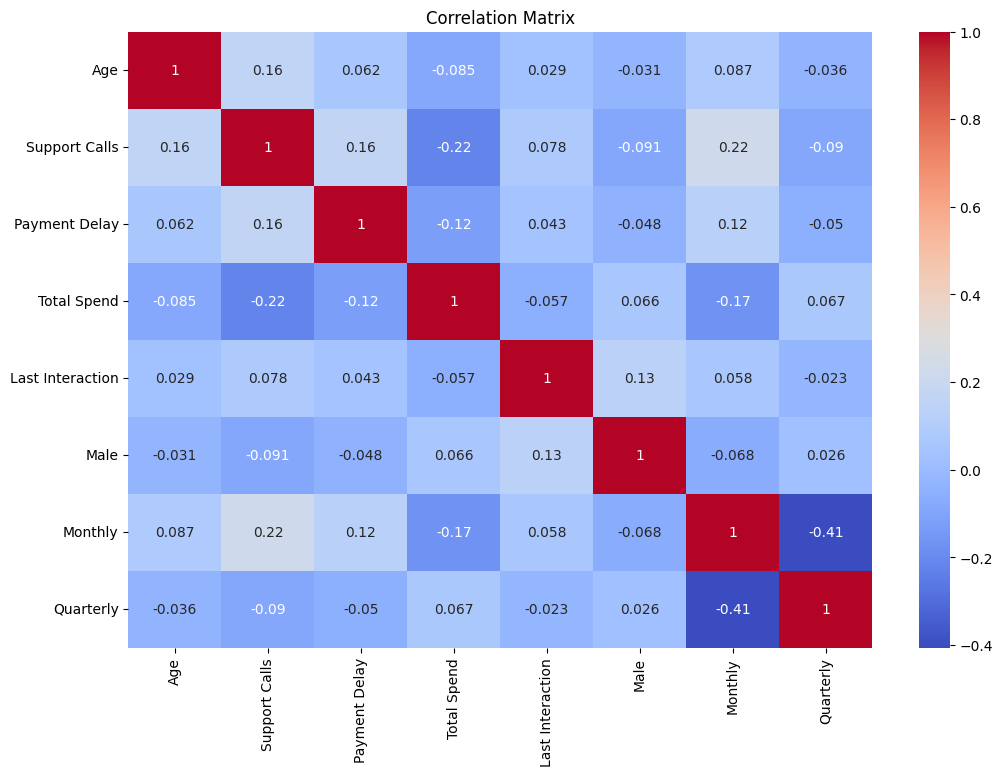

In [17]:
# correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Summary Statistics

After our final feature selection, we see the summary statistics of the data that we have in our hands

In [18]:
X_train.describe()

,Age,Support Calls,Payment Delay,Total Spend,Last Interaction,Male,Monthly,Quarterly
count,4.408320e+05,4.408320e+05,4.408320e+05,4.408320e+05,4.408320e+05,4.408320e+05,4.408320e+05,4.408320e+05
mean,7.994637e-17,4.332578e-17,-3.094698e-18,-8.304107e-16,1.191459e-16,-1.959976e-17,-8.458842e-17,2.269445e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.717774e+00,-1.174002e+00,-1.570070e+00,-2.207684e+00,-1.568236e+00,-1.145909e+00,-4.962315e-01,-8.172577e-01
25%,-8.336969e-01,-8.482914e-01,-8.435065e-01,-6.296283e-01,-8.702531e-01,-1.145909e+00,-4.962315e-01,-8.172577e-01
50%,-2.999058e-02,-1.968711e-01,-1.169430e-01,1.220243e-01,-5.593961e-02,8.726697e-01,-4.962315e-01,-8.172577e-01
75%,6.933451e-01,7.802593e-01,7.307144e-01,8.238436e-01,8.747044e-01,8.726697e-01,-4.962315e-01,1.223604e+00
max,2.059646e+00,2.083100e+00,2.062747e+00,1.529816e+00,1.805348e+00,8.726697e-01,2.015188e+00,1.223604e+00


# Machine Learning

We implement 3 popular ML models here  
1) Logistic Regression
2) XGBoost
3) Random Forest

After training and testing, we evaluate the performance using the metrics accuracy, precision, recall and F1-score

In [19]:
def evaluate_model(model, X_test, y_test, model_name):
    # predict on the test set
    y_pred = model.predict(X_test)
    
    # evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # print the results
    print(f'--------------- {model_name} ---------------')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-Score: {f1}')

### Logistic Regression

In [20]:
# train logistic regression model
log_reg = LogisticRegression(max_iter = 1000, random_state=0)
log_reg.fit(X_train, y_train)

# evaluate the model
evaluate_model(log_reg, X_test, y_test, "Logistic Regression")

--------------- Logistic Regression ---------------
Accuracy: 0.645276043123
Precision: 0.5909371585997245
Recall: 0.8159905552093923
F1-Score: 0.6854639871072604


### XGBoost

In [21]:
# train xgboost model
xgb_model = XGBClassifier(random_state=0)
xgb_model.fit(X_train, y_train)

# evaluate the model
evaluate_model(xgb_model, X_test, y_test, "XGBoost")

--------------- XGBoost ---------------
Accuracy: 0.563736912418057
Precision: 0.5218948248595786
Recall: 0.9415603581149772
F1-Score: 0.6715552124997076


### Random Forest

In [22]:
# train random forest model
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)

# evaluate the model
evaluate_model(rf_model, X_test, y_test, "Random Forest")

--------------- Random Forest ---------------
Accuracy: 0.5369248454344921
Precision: 0.5058541184537585
Recall: 0.9677302987570918
F1-Score: 0.6644076192191651


##### Comparing the 4 metrics we see that only except Recall, <font color = "Red"> Logistic Regression </font> outperforms the other two models in other three metrics. Also, in terms of Accuracy, this model has the best score of 64.5%. So, we select the Logistic Regression model for our Churn prediction task

In [23]:
# helper functions to save and load the model
def save_model(file, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(file, f)
    print(f'saved model to {filepath}')

def load_model(filepath):
    try:
        with open(filepath, 'rb') as f:
            file = pickle.load(f)
        return file
    except e:
        print(f'file {filepath} not found!')
        return

In [24]:
model_path = 'customer_churn/log_reg.pkl'

# save the model in the path
save_model(log_reg, model_path)

saved model to customer_churn/log_reg.pkl


### Prediction on New Data

This section is for predicting customer churn on new data with the logistic regression model. The new data should possess the same structure (same columns) as the primary data. The columns are  

CustomerID  
Age  
Gender  
Tenure  
Usage Frequency  
Support Calls  
Payment Delay  
Subscription Type  
Contract Length  
Total Spend  
Last Interaction  

These columns will get converted to numerical columns and their appropriate dummy values accordingly by the function **preprocess_new_data** 

In [25]:
# this function converts the new data into encoded data wherever applicable
def preprocess_new_data(new_data, gender_columns, sub_type_columns, contract_len_columns, columns_to_drop, scaler):

    if 'CustomerID' in new_data.columns:
        new_data.drop(['CustomerID'], inplace = True, axis = 1)
    
    # create dummy columns for new data
    gender_new = pd.get_dummies(new_data['Gender'], dtype=float)
    sub_type_new = pd.get_dummies(new_data['Subscription Type'], dtype=float)
    contract_len_new = pd.get_dummies(new_data['Contract Length'], dtype=float)
    
    # align columns with the stored columns (add missing columns with 0 values)
    gender_new = gender_new.reindex(columns=gender_columns, fill_value=0)
    sub_type_new = sub_type_new.reindex(columns=sub_type_columns, fill_value=0)
    contract_len_new = contract_len_new.reindex(columns=contract_len_columns, fill_value=0)

    # print(gender_new.columns, gender_columns)
    # print(sub_type_new.columns, sub_type_columns)
    # print(contract_len_new.columns, contract_len_columns)
    
    new_data.drop(['Gender', 'Subscription Type', 'Contract Length'], inplace = True, axis = 1)
    
    # combine all data into one dataframe
    X_new = pd.concat([new_data, gender_new, sub_type_new, contract_len_new], axis=1)
    
    # Scale the data using the stored scaler
    X_new_scaled = pd.DataFrame(scaler.fit_transform(X_new), columns = X_new.columns)
    X_new_scaled.drop(columns_to_drop, inplace = True, axis = 1)
    
    return X_new_scaled

In [26]:
# load the model 
model = load_model(model_path)

In [27]:
# sample new data
new_data = pd.DataFrame({
    'CustomerID' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Age': [25, 45, 35, 50, 23, 44, 36, 30, 39, 41],
    'Gender': ['Female', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Male', 'Female', 'Female'],
    'Tenure': [12, 24, 18, 36, 12, 24, 30, 15, 28, 22],
    'Usage Frequency': [5, 3, 4, 2, 6, 5, 4, 5, 3, 4],
    'Support Calls': [1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
    'Payment Delay': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    'Subscription Type': ['Standard', 'Basic', 'Premium', 'Basic', 'Standard', 'Premium', 'Basic', 'Standard', 'Premium', 'Basic'],
    'Contract Length': ['Monthly', 'Annual', 'Quarterly', 'Annual', 'Monthly', 'Quarterly', 'Annual', 'Monthly', 'Quarterly', 'Annual'],
    'Total Spend': [200, 300, 250, 400, 220, 350, 275, 290, 310, 330],
    'Last Interaction': [10, 20, 30, 40, 50, 10, 20, 30, 40, 50],
})

# preprocess the new data using the stored encodings and scaler
# also drop the required columns that were excluded midway during EDA (columns_to_drop)
X_new = preprocess_new_data(new_data.iloc[:,:], gender_tr.columns, sub_type_tr.columns, contract_len_tr.columns, columns_to_drop, scaler)
print("Preprocessed new data:", X_new)


Preprocessed new data:         Age  Support Calls  Payment Delay  Total Spend  Last Interaction  \
0 -1.414823      -1.414214           -1.0    -1.620999         -1.414214   
1  0.983182      -0.707107            1.0     0.131432         -0.707107   
2 -0.215821       0.000000           -1.0    -0.744784          0.000000   
3  1.582684       0.707107            1.0     1.883864          0.707107   
4 -1.654624       1.414214           -1.0    -1.270513          1.414214   
5  0.863282      -1.414214            1.0     1.007648         -1.414214   
6 -0.095920      -0.707107           -1.0    -0.306676         -0.707107   
7 -0.815322       0.000000            1.0    -0.043811          0.000000   
8  0.263781       0.707107           -1.0     0.306676          0.707107   
9  0.503581       1.414214            1.0     0.657162          1.414214   

       Male   Monthly  Quarterly  
0 -0.816497  1.527525  -0.654654  
1 -0.816497 -0.654654  -0.654654  
2  1.224745 -0.654654   1.527525  


#### Predict for new data

A churned customer (Churn = 1) is one who has decided to discontinue their subscription or usage of the company's services. On the other hand, a non-churned customer (Churn = 0) is one who continues to remain engaged and retains their relationship with the company.

In [593]:
y_new = model.predict(X_new)

print(f'Prediction for X_new : \n{y_new}')

Prediction for X_new : 
[1. 0. 0. 1. 1. 0. 0. 1. 1. 1.]
